In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset

block_size = 3 # context length: how many chars do we take to predict the next one?
X, Y = [], []
for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [7]:
C = torch.randn((27, 2))

In [8]:
C[15]

tensor([-0.2372, -0.7871])

In [9]:
F.one_hot(torch.tensor(15), num_classes=27).float() @ C

tensor([-0.2372, -0.7871])

In [10]:
C[X].shape

torch.Size([228146, 3, 2])

In [11]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [12]:
W1 = torch.randn([6, 100])
b1 = torch.randn(100)

In [13]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([228146, 6])

In [14]:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([228146, 6])

In [15]:
emb.shape

torch.Size([228146, 3, 2])

In [17]:
emb.view(-1,6).shape

torch.Size([228146, 6])

In [18]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)

In [19]:
h.shape

torch.Size([228146, 100])

In [20]:
W2 = torch.randn(size=(100,27))
b2 = torch.randn(27)

In [21]:
logits = h @ W2 + b2

In [22]:
logits.shape

torch.Size([228146, 27])

In [23]:
counts = logits.exp()

In [24]:
prob = counts / counts.sum(1, keepdim=True)

In [25]:
prob[0].sum()

tensor(1.0000)

In [31]:
loss = -prob[torch.arange(X.shape[0]), Y].log().mean()

In [32]:
loss

tensor(17.5690)

In [33]:
###  ----------- done better :] ------- ###

In [34]:
X.shape, Y.shape # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [80]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn(size=(27, 2), generator=g)
W1 = torch.randn(size=(6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn(size=(100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [73]:
sum(p.nelement() for p in parameters) # no. of total params

3481

In [38]:
emb = C[X]  # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2   #(32, 27)
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
loss = -prob[torch.arange(X.shape[0]), Y].log().mean()
loss

tensor(19.5052)

In [39]:
loss = F.cross_entropy(logits, Y)
loss

tensor(19.5052)

In [81]:
for p in parameters:
    p.requires_grad = True

In [75]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [ ]:
lri = []
lossi = []
for i in range(10000):

    # mini batch construct
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass
    emb = C[X[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2   #(32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # lr = lrs[i]
    lr = 0.1
    for p in parameters:
        p.data -= lr * p.grad 

    # track stats
    # lri.append(lr)
    # lossi.append(loss.item())
    
print(loss.item())

1.9094430208206177


In [98]:
emb = C[X]  # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2   #(32, 27)
loss = F.cross_entropy(logits, Y)
loss.item()

2.275871992111206

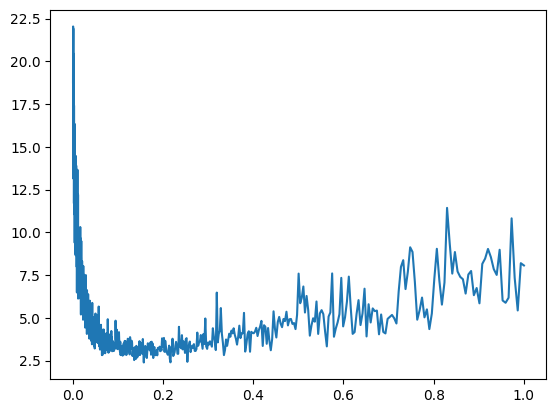

In [77]:
plt.plot(lri, lossi)